In [51]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras import layers
from keras import regularizers
from keras import metrics
from keras.saving import save_model
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [7]:
if not os.path.exists('../data/generated/text_files/val/'):
    os.mkdir('../data/generated/text_files/val')
    
val_dir = f"../data/generated/text_files/val/"
train_dir = f"../data/generated/text_files/train/"


The following section moves text files from the training collection to validation for NN training. 

In [8]:
# Taking special care to make sure that augmented recipes (variants of existing ones) don't end up in both
# train AND validation, we selectively create val from the end of the augmented data so there is no
# leakage




if not os.path.exists(os.path.join(val_dir, 'pos')):
    os.mkdir(os.path.join(val_dir, 'pos'))

kf_files = os.listdir(os.path.join(train_dir, 'pos'))
kf_test_files = kf_files[:1000]

for f in kf_test_files:
  shutil.move(f"{train_dir}/pos/{f}", f"{val_dir}/pos/{f}")

In [9]:
# Non kidney friendly recipes were not augmented and therefore the validation set can be random

if not os.path.exists(os.path.join(val_dir, 'neg')):
  os.mkdir(os.path.join(val_dir, 'neg'))

nkf_files = os.listdir(os.path.join(train_dir, 'neg'))
n_train = len(nkf_files)
nkf_test_files = np.random.choice(nkf_files, 1000, replace = False)

for f in nkf_test_files:
  shutil.move(f"{train_dir}/neg/{f}", f"{val_dir}/neg/{f}")

In [10]:
len(os.listdir(os.path.join(val_dir,'pos')))


1000

In [11]:
len(os.listdir(os.path.join(val_dir,'neg')))

1000

### Download and unzip GloVe

These files of word vectors are too large to manage in this repo and if necessary, can be obtained here. Unzip the collection archives and move the named files to your working directory.

https://nlp.stanford.edu/projects/glove/

This project used the following:
| Collection | Vector File |
|---|---|
| Wikipedia 2014 + GigaWord 5 | glove.6B.100d |
| Common Crawl 42B | glove.42B.300d |

In [52]:
# Create Keras datasets from recipe files

batch_size = 32
train_ds = keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory(val_dir, batch_size=batch_size)


Found 16696 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [53]:
# extract just the vocabulary

text_only_train_ds = train_ds.map(lambda x,y : x)

In [54]:
# use manual vectorization 

max_length = 100
max_tokens = 20_000

text_vectorization = keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_mode = 'int',
    output_sequence_length=max_length
)

text_vectorization.adapt(text_only_train_ds)

In [56]:
# with open('text_vectorization.pkl', 'wb') as f:
#     pickle.dump({'config': text_vectorization.get_config(),
#                  'weights': text_vectorization.get_weights()}, f)

In [15]:
text_vectorization('''
100 grams beans
1 cup sugar''')

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([229,   2, 160,  85,  77,  20,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int64)>

In [16]:
# map the vocabulary to an int, keep the label as is

int_mapper = lambda x,y: (text_vectorization(x), y)


int_train_ds = train_ds.map(int_mapper, num_parallel_calls=4 )
int_val_ds = val_ds.map(int_mapper, num_parallel_calls=4 )

In [17]:
# confirm Tensor shape - will factor into predictions
for x,y in int_train_ds:
    break
x.shape
# 32 for batch size, 100 is max length

TensorShape([32, 100])

### Model 1 - Manually training vectors

In [19]:
# compile the model

inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(
    input_dim=max_tokens,
    output_dim=256,
    mask_zero = True
)(inputs)
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer = regularizers.L1L2(l1=0.01, l2=0.01)) )(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(inputs,outputs)
model_1.compile(optimizer='rmsprop', loss='bce', metrics=[metrics.Precision(), 'acc'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                             

In [20]:
# fit the model and record one model per epoch

filepath = "models/manual_vectors/manual_vectors_{epoch}.keras"
mc = ModelCheckpoint(filepath, monitor='val_precision', mode='max', save_best_only=False)
res = model_1.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=[mc]
)




Epoch 1/10
522/522 [==============================] - 65s 108ms/step - loss: 3.4974 - precision: 0.9338 - acc: 0.9289 - val_loss: 2.0692 - val_precision: 0.9772 - val_acc: 0.6885
Epoch 2/10
522/522 [==============================] - 53s 101ms/step - loss: 0.4301 - precision: 0.9804 - acc: 0.9826 - val_loss: 1.4898 - val_precision: 0.9688 - val_acc: 0.7405
Epoch 3/10
522/522 [==============================] - 54s 103ms/step - loss: 0.3935 - precision: 0.9873 - acc: 0.9891 - val_loss: 1.4062 - val_precision: 0.9746 - val_acc: 0.7615
Epoch 4/10
522/522 [==============================] - 56s 108ms/step - loss: 0.3807 - precision: 0.9890 - acc: 0.9911 - val_loss: 2.0183 - val_precision: 0.9819 - val_acc: 0.6865
Epoch 5/10
522/522 [==============================] - 57s 109ms/step - loss: 0.3799 - precision: 0.9908 - acc: 0.9916 - val_loss: 1.2370 - val_precision: 0.9619 - val_acc: 0.7910
Epoch 6/10
522/522 [==============================] - 57s 109ms/step - loss: 0.3733 - precision: 0.9917 -

KeyError: 'va_acc'

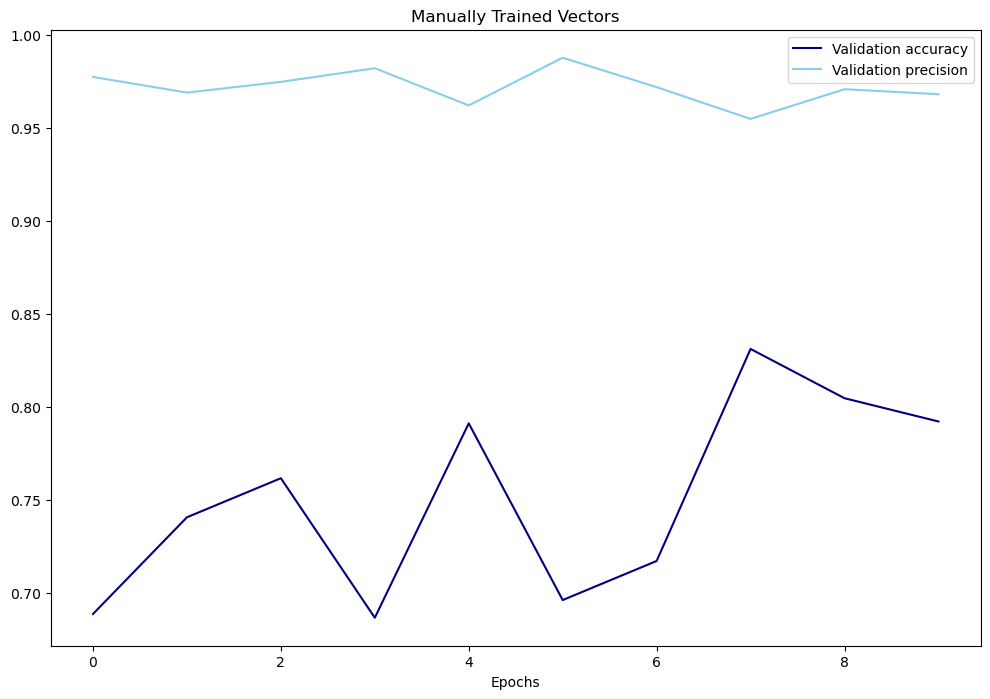

In [22]:
# Visualize stats
val_acc = res.history['va_acc']
val_precision = res.history['val_precision']
plt.figure(figsize=(12, 8))
plt.title('Manually Trained Vectors')

plt.plot(val_acc, label='Validation accuracy', color='navy')
plt.plot(val_precision, label='Validation precision', color='skyblue')
plt.xlabel('Epochs')
plt.legend();

### Set up GloVe pretrained vectors

In [23]:
embeddings_ix = {}

# create a dictionary that contains each word in vocabulary and its coefs
with open('../data/GloVe/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, 'f', sep=' ')
    embeddings_ix[word] = coefs

In [24]:
embedding_dim = 100

# get the vocab from the vectorization from earlier
vocab = text_vectorization.get_vocabulary()

# create a dictionary from enumerating the words in vocab
word_ix = dict(enumerate(vocab))
word_ix = {word: i for i, word in word_ix.items()}

In [25]:
print(word_ix['sodium'])

158


In [26]:
# create an array of all zeroes of size 20_000 x 100
embedding_mx = np.zeros((max_tokens, embedding_dim))

# for each word, create an embed vector derived from GloVe
for word, i in word_ix.items():
  if i < max_tokens:
    embed_vector = embeddings_ix.get(word)

  if embed_vector is not None:
    embedding_mx[i, :] = embed_vector

In [27]:
# sanity check - word sodium
embedding_mx[158, :5]

array([-0.93567002,  0.3705    , -0.11117   , -0.037242  , -0.071873  ])

In [28]:
embeddings_ix['sodium'][:5]

array([-0.93567 ,  0.3705  , -0.11117 , -0.037242, -0.071873],
      dtype=float32)

In [29]:
# create a glove layer to replace custom embedding
glove_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_mx),
    trainable=False,
    mask_zero=True
)

In [30]:
#compile new model
inputs = keras.Input(shape=(None,))
embedded = glove_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer = regularizers.L1L2(l1=0.01, l2=0.01)))(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs,outputs)
model2.compile(optimizer='rmsprop', loss='bce', metrics=[metrics.Precision(),'acc'])
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                           

In [33]:
filepath = "models/glove6B-100d/glove6B-100d_{epoch}.keras"
mc = ModelCheckpoint(filepath, monitor='val_precision', mode='max', save_best_only=False)
# es = EarlyStopping(monitor='acc', mode='max', patience = 3, min_delta = 0.01)
res = model2.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=[mc]
)



Epoch 1/10
522/522 [==============================] - 50s 96ms/step - loss: 0.7543 - precision_1: 0.7967 - acc: 0.8012 - val_loss: 0.8131 - val_precision_1: 0.7174 - val_acc: 0.7570
Epoch 2/10
522/522 [==============================] - 44s 84ms/step - loss: 0.6228 - precision_1: 0.8441 - acc: 0.8536 - val_loss: 0.7037 - val_precision_1: 0.8483 - val_acc: 0.8190
Epoch 3/10
522/522 [==============================] - 43s 83ms/step - loss: 0.5734 - precision_1: 0.8634 - acc: 0.8751 - val_loss: 0.7942 - val_precision_1: 0.9684 - val_acc: 0.7665
Epoch 4/10
522/522 [==============================] - 43s 83ms/step - loss: 0.5415 - precision_1: 0.8785 - acc: 0.8874 - val_loss: 0.6465 - val_precision_1: 0.8457 - val_acc: 0.8405
Epoch 5/10
522/522 [==============================] - 44s 84ms/step - loss: 0.5306 - precision_1: 0.8836 - acc: 0.8958 - val_loss: 0.6887 - val_precision_1: 0.9191 - val_acc: 0.8470
Epoch 6/10
522/522 [==============================] - 43s 83ms/step - loss: 0.5128 - preci

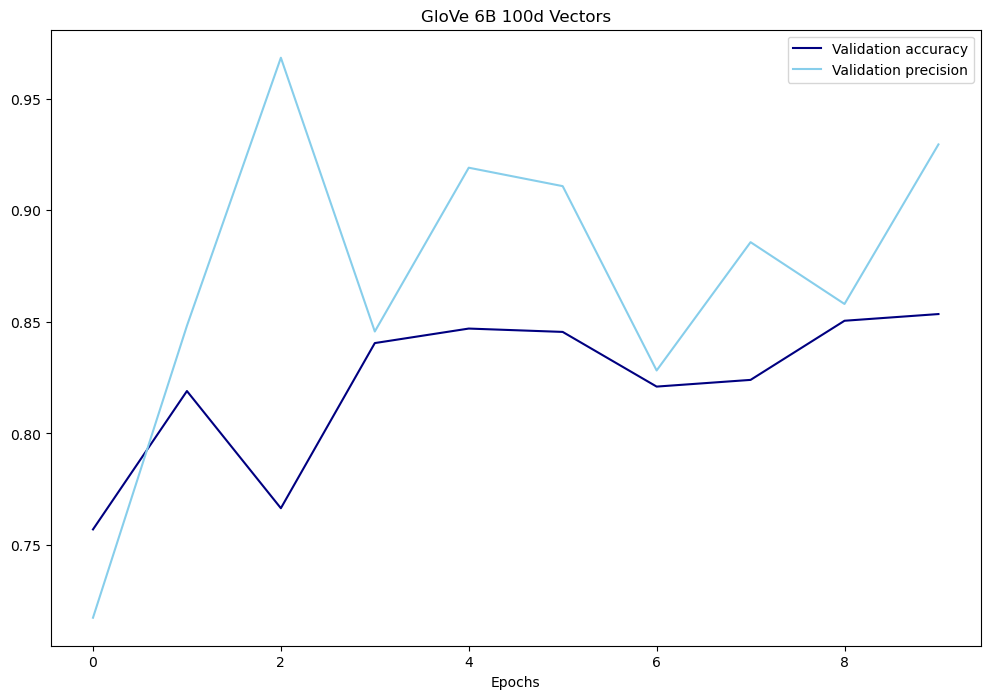

In [39]:
# Visualize stats
val_acc = res.history['val_acc']
val_precision = res.history['val_precision_1']
plt.figure(figsize=(12, 8))
plt.title('GloVe 6B 100d Vectors')

plt.plot(val_acc, label='Validation accuracy', color='navy')
plt.plot(val_precision, label='Validation precision', color='skyblue')
plt.xlabel('Epochs')
plt.legend();

### GloVe 42B 300d - same principle as above but larger

In [40]:
embeddings_ix = {}

with open('../data/GloVe/glove.42B.300d.txt', 'r', encoding='utf-8') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, 'f', sep=' ')
    embeddings_ix[word] = coefs

In [41]:
embedding_dim = 300

vocab = text_vectorization.get_vocabulary()
word_ix = dict(enumerate(vocab))
word_ix = {word: i for i, word in word_ix.items()}

In [ ]:
print(word_ix['sodium'])

In [42]:
embedding_mx = np.zeros((max_tokens, embedding_dim))

for word, i in word_ix.items():
  if i < max_tokens:
    embed_vector = embeddings_ix.get(word)

  if embed_vector is not None:
    embedding_mx[i, :] = embed_vector

In [43]:
embedding_mx[158, :5]

array([ 0.017378  , -0.51845998,  0.55386001, -0.84460998,  0.17639001])

In [44]:
embeddings_ix['sodium'][:5]

array([ 0.017378, -0.51846 ,  0.55386 , -0.84461 ,  0.17639 ],
      dtype=float32)

In [45]:
glove_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_mx),
    trainable=False,
    mask_zero=True
)

In [46]:
inputs = keras.Input(shape=(None,))
embedded = glove_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer = regularizers.L1L2(l1=0.01, l2=0.01)))(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = keras.Model(inputs,outputs)
model_3.compile(optimizer='rmsprop', loss='bce', metrics=[metrics.Precision(), 'acc'])
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 300)         6000000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                85248     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                           

In [49]:
filepath = "models/glove42B-300d/glove42B-300d_{epoch}.keras"
mc = ModelCheckpoint(filepath, save_best_only=False)
res = model_3.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=[mc]
)



Epoch 1/10
522/522 [==============================] - 93s 179ms/step - loss: 1.0129 - precision_2: 0.7680 - acc: 0.7444 - val_loss: 1.0443 - val_precision_2: 0.8027 - val_acc: 0.7915
Epoch 2/10
522/522 [==============================] - 87s 167ms/step - loss: 0.8960 - precision_2: 0.8437 - acc: 0.8408 - val_loss: 1.0079 - val_precision_2: 0.9128 - val_acc: 0.7650
Epoch 3/10
522/522 [==============================] - 87s 167ms/step - loss: 0.8494 - precision_2: 0.8730 - acc: 0.8753 - val_loss: 1.0454 - val_precision_2: 0.9668 - val_acc: 0.7670
Epoch 4/10
522/522 [==============================] - 87s 166ms/step - loss: 0.8266 - precision_2: 0.8869 - acc: 0.8897 - val_loss: 0.9636 - val_precision_2: 0.8973 - val_acc: 0.8210
Epoch 5/10
522/522 [==============================] - 87s 166ms/step - loss: 0.8081 - precision_2: 0.8970 - acc: 0.9021 - val_loss: 2.5096 - val_precision_2: 1.0000 - val_acc: 0.5130
Epoch 6/10
522/522 [==============================] - 86s 166ms/step - loss: 0.8057 -

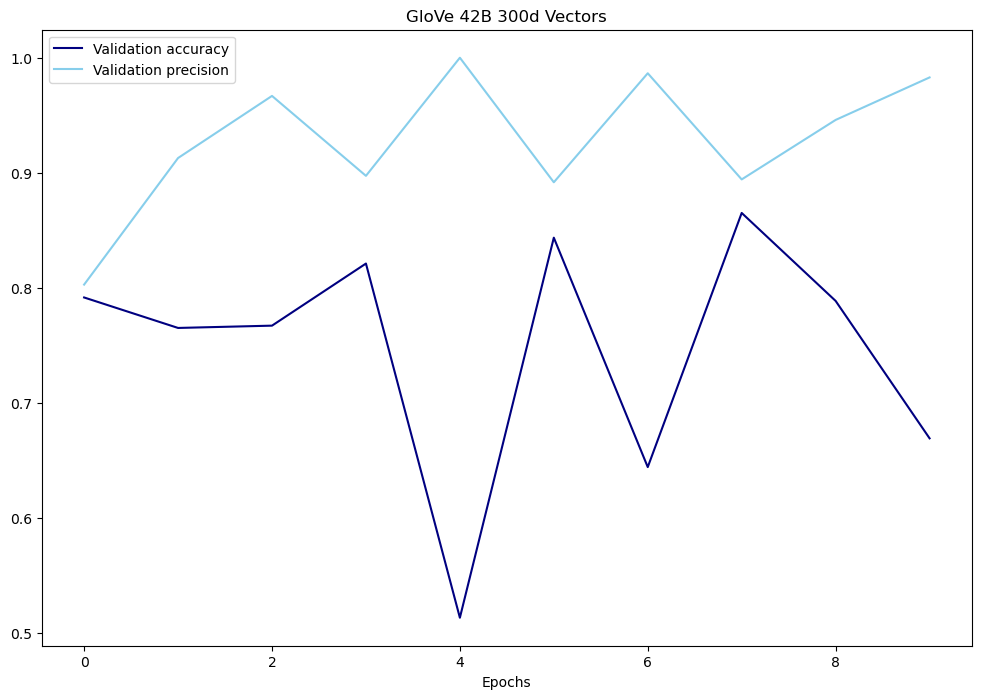

In [50]:
# Visualize stats
val_acc = res.history['val_acc']
val_precision = res.history['val_precision_2']
plt.figure(figsize=(12, 8))
plt.title('GloVe 42B 300d Vectors')

plt.plot(val_acc, label='Validation accuracy', color='navy')
plt.plot(val_precision, label='Validation precision', color='skyblue')
plt.xlabel('Epochs')
plt.legend();